In [1]:
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary, meshtags
from ufl import grad, inner, split
from dolfinx import plot, default_scalar_type
from dolfinx.nls.petsc import NewtonSolver

import pyvista

In [2]:
length = 10.0
width = 1.0

cell_type = CellType.quadrilateral

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, -width/2.0], [length, width/2.0]]), [10, 1], cell_type)
tdim = mesh.topology.dim
fdim = tdim - 1

In [3]:
from pathlib import Path

results_folder = Path("results/nonlinear_Naghdi/shear-up_cantilever")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista.start_xvfb()

plot mesh

In [16]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:36395/index.html?ui=P_0x7faccba4c1a0_0&reconnect=auto" class="pyvi…

material

In [4]:
E, nu = Constant(mesh, default_scalar_type(1.2E6)), Constant(mesh, default_scalar_type(0.0))
mu = E/(2.0*(1.0 + nu))
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu)
t = Constant(mesh, default_scalar_type(1E-1))

initial shape

In [5]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([x[0], x[1], 0])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))


n0_ufl = unit_normal(phi0_ufl)

cell = mesh.basix_cell()
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

shell element

In [6]:
# for 2 rotation DOFs, we use P2 element
# mixed element for u and theta

if cell_type == CellType.triangle:
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
    
elif cell_type == CellType.quadrilateral:
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)
q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

shell model

In [7]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

External work

In [8]:
def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], length)

left_facets = locate_entities_boundary(mesh, fdim, left)
right_facets = locate_entities_boundary(mesh, fdim, right)

# left facets are marked with tag 1, right facets are marked with tag 2
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2)])
sorted_facets = np.argsort(marked_facets)
facet_tag = meshtags(mesh, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

P_right = Constant(mesh, default_scalar_type(0.0))

ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag, metadata={"quadrature_degree": 2})

W_ext = P_right * u_func[2] * ds(2)

Potential energy with PSRI

In [9]:
# Full integration of order 4
dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Reduced integration of order 2
dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

clamped left boundary condtions

In [10]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, facet_tag.find(1))
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, facet_tag.find(1))
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

bcs = [bc_clamped_u, bc_clamped_theta]

bb tree

In [11]:
bb_tree = dolfinx.geometry.bb_tree(mesh, 2)
bb_point = np.array([[length, 0.0, 0.0]], dtype=np.float64)

# Find the leaf that the target point is in
bb_cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point)

# Find the cell from the leaf that contains the target point
bb_cells = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates, bb_point)

newton solver

In [12]:
problem = NonlinearProblem(Residual, q_func, bcs, Jacobian)
solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 30
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [13]:
P_max = 4.0*E.value*t.value**3/(12.0*length**2)
nstep = 20
Ps = np.linspace(0.0, P_max, nstep)

if mesh.comm.rank == 0:
    u1_list = np.zeros(nstep)
    u3_list = np.zeros(nstep)
    
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u_naghdi.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta_naghdi.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi_naghdi.pvd", "w")
 
q_func.x.array[:] = 0.0
#log.set_log_level(log.LogLevel.INFO)
#log.set_log_level(log.LogLevel.OFF)

for i, P_curr in enumerate(Ps):
    P_right.value = P_curr
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {P_curr / P_max:.2f}", flush=True)
    
    # write output
    u_P2B3 = q_func.sub(0).collapse()
    theta_P2 = q_func.sub(1).collapse()

    phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
    phi_expr = Expression(phi0_ufl + u_P2B3, phi_FS.element.interpolation_points())
    phi_func = Function(phi_FS)
    phi_func.interpolate(phi_expr)

    u_P2 = Function(phi_FS)
    u_P2.interpolate(u_P2B3)

    file_u.write_function(u_P2, i)
    
    file_theta.write_function(theta_P2, i)
    
    file_phi.write_function(phi_func, i)
    
    # calculate u3 at the point load
    u1_bb = None
    u3_bb = None
    u1_func = q_func.sub(0).sub(0).collapse()
    u3_func = q_func.sub(0).sub(2).collapse()
    if len(bb_cells.array) > 0:
        u1_bb = u1_func.eval(bb_point, bb_cells.array[0])[0]
        u3_bb = u3_func.eval(bb_point, bb_cells.array[0])[0]
    u1_bb = mesh.comm.gather(u1_bb, root=0)
    u3_bb = mesh.comm.gather(u3_bb, root=0)
    if mesh.comm.rank == 0:
        for u1 in u1_bb:
            if u1 is not None:
                u1_list[i] = u1
                break
            
        for u3 in u3_bb:
            if u3 is not None:
                u3_list[i] = u3
                break

# close the output files
file_u.close()
file_theta.close()
file_phi.close()

Load step 0, Number of iterations: 2, Load: 0.00
Load step 1, Number of iterations: 5, Load: 0.05
Load step 2, Number of iterations: 6, Load: 0.11
Load step 3, Number of iterations: 7, Load: 0.16
Load step 4, Number of iterations: 7, Load: 0.21
Load step 5, Number of iterations: 7, Load: 0.26
Load step 6, Number of iterations: 7, Load: 0.32
Load step 7, Number of iterations: 7, Load: 0.37
Load step 8, Number of iterations: 7, Load: 0.42
Load step 9, Number of iterations: 6, Load: 0.47
Load step 10, Number of iterations: 6, Load: 0.53
Load step 11, Number of iterations: 6, Load: 0.58
Load step 12, Number of iterations: 6, Load: 0.63
Load step 13, Number of iterations: 6, Load: 0.68
Load step 14, Number of iterations: 6, Load: 0.74
Load step 15, Number of iterations: 6, Load: 0.79
Load step 16, Number of iterations: 6, Load: 0.84
Load step 17, Number of iterations: 6, Load: 0.89
Load step 18, Number of iterations: 5, Load: 0.95
Load step 19, Number of iterations: 5, Load: 1.00


In [18]:
u_P2B3 = q_func.sub(0).collapse()

phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
phi_expr = Expression(phi0_ufl + u_P2B3, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)

topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:36395/index.html?ui=P_0x7faccb3bc4d0_0&reconnect=auto" class="pyvi…

plot displacement versus load

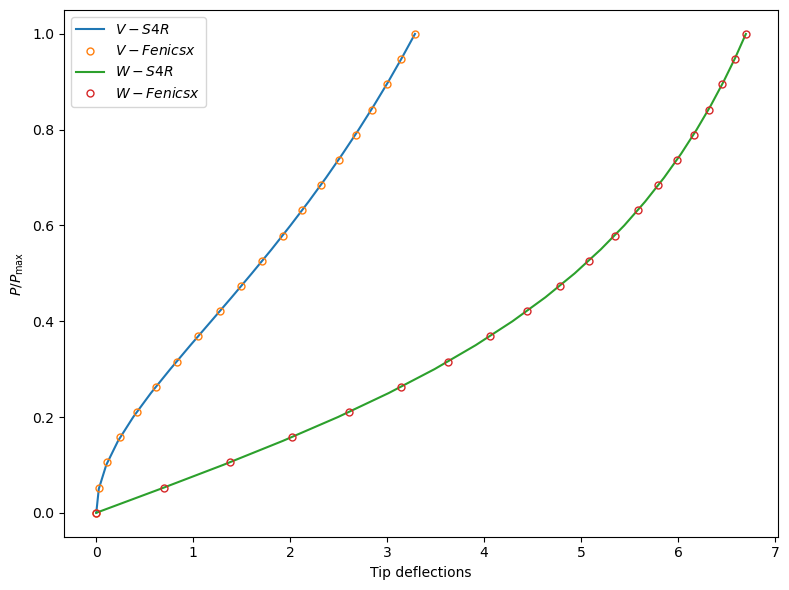

In [15]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    P_S4R = np.array([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                      0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.0])
    
    U_S4R = np.array([0.0, 0.026, 0.103, 0.224, 0.381, 0.563, 0.763, 0.971, 1.184, 1.396, 1.604,
                      1.807, 2.002, 2.190, 2.370, 2.541, 2.705, 2.861, 3.010, 3.151, 3.286])
    
    W_S4R = np.array([0.0, 0.663, 1.309, 1.922, 2.493, 3.015, 3.488, 3.912, 4.292, 4.631, 4.933,
                      5.202, 5.444, 5.660, 5.855, 6.031, 6.190, 6.335, 6.467, 6.588, 6.698])
    
    fig = plt.figure(figsize=(8.0, 6.0))
    plt.plot(U_S4R, P_S4R, "-", label="$V-S4R$")
    plt.plot(-u1_list, Ps/P_max, "o", markersize=5, markerfacecolor='none', label="$V-Fenicsx$")
    plt.plot(W_S4R, P_S4R, "-", label="$W-S4R$")
    plt.plot(u3_list, Ps/P_max, "o", markersize=5, markerfacecolor='none', label="$W-Fenicsx$")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.xlabel("Tip deflections")
    plt.legend()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png")